In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'nearest'
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from skimage import io
from skimage import feature
from skimage.feature import hog
from glob import glob
import re

In [3]:
from ipywidgets import interact

In [4]:
def browse_images_overlay(image, image2):
    x, y, z = image.shape
    def view_image(i):
        plt.figure(figsize=(8,8))
        plt.imshow(image2[i,:, :], interpolation='nearest', cmap='gray')
        plt.imshow(image[:,:, i], interpolation='nearest', cmap = 'viridis', alpha=0.4)
        plt.show()
    interact(view_image, i=(0,z-1),continuous_update=False)

In [5]:
def browse_images(image):
    z, x, y = image.shape
    def view_image(i):
        plt.figure(figsize=(8,8))
        plt.imshow(image[i,:, :], interpolation='nearest', cmap = 'viridis', vmax=image.max()/2)
        plt.show()
    interact(view_image, i=(0,z-1),continuous_update=False)

In [6]:
path = "/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/training_set_mip/positive/"

In [7]:
path_n = "/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/training_set_mip/negative/"

In [8]:
positive = []
titles_pos = []
for files in glob(path + '*.tif'): 
    titles_pos.append(re.findall('\d+.tif', files ))
    positive.append(io.imread(files))

In [9]:
negative = []
titles_neg = []
for files in glob(path_n + '*.tif'):
    titles_neg.append(re.findall('\d+_n.tif', files ))
    negative.append(io.imread(files))

In [10]:
X1 = np.squeeze(np.stack(positive))

In [11]:
X2 = np.squeeze(np.stack(negative))

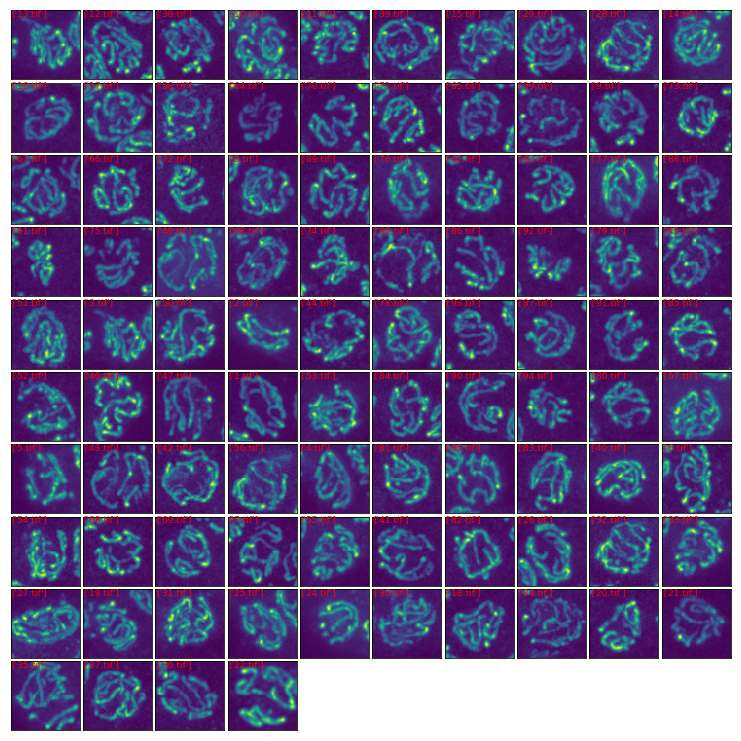

In [12]:
# set up the figure
fig = plt.figure(figsize=(10, 10))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the faces:
for i in range(len(X1)):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(X1[i, :, :], interpolation='nearest')
    ax.text(0, 5, str(titles_pos[i]), color="red", fontsize=9)

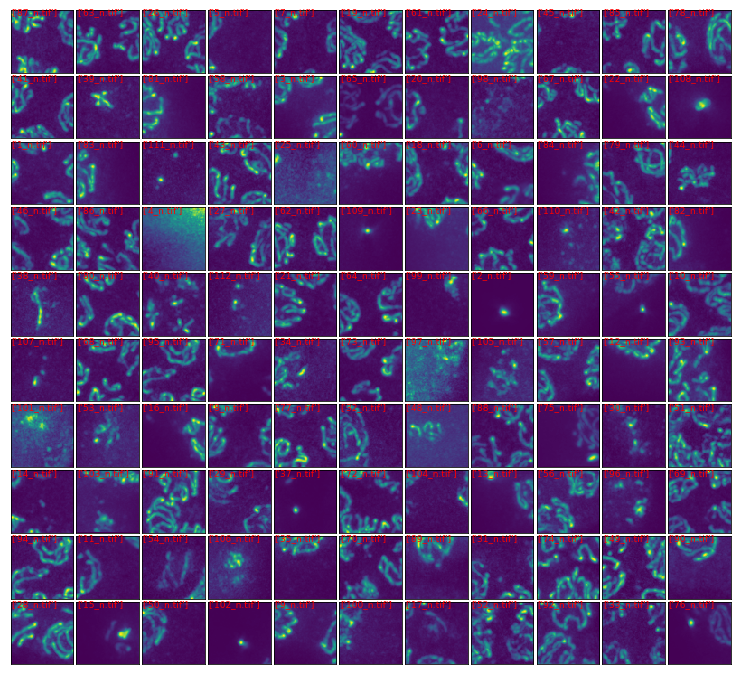

In [13]:
# set up the figure
fig = plt.figure(figsize=(10, 10))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the faces:
for i in range(len(X2)):
    ax = fig.add_subplot(11, 11, i + 1, xticks=[], yticks=[])
    ax.imshow(X2[i, :, :], interpolation='nearest')
    ax.text(0, 5, str(titles_neg[i]), color="red", fontsize=9)

# Feature X (Pos, X1 and Neg, X2)

In [14]:
X = np.vstack((X1,X2))

# Example HoG (Histo of horiented Gradient)  feature on chromosome

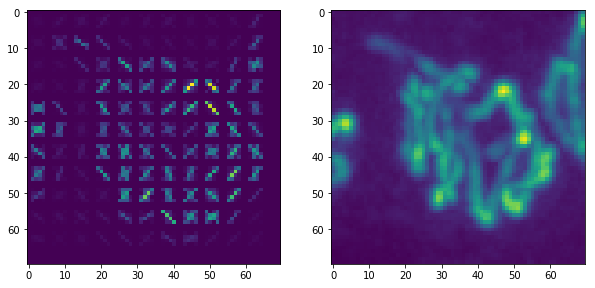

In [15]:
fd, hog_image = hog(X[0], orientations=8, pixels_per_cell=(6, 6),block_norm='L1',
                    cells_per_block=(3, 3), visualize=True, multichannel=False)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(hog_image)
ax[1].imshow(X[0])

# Target Y, either 0 (Neg) or 1 (Pos)

In [16]:
y_pos = np.ones(len(X1))
y_neg = np.zeros(len(X2))
Y = np.hstack((y_pos, y_neg))

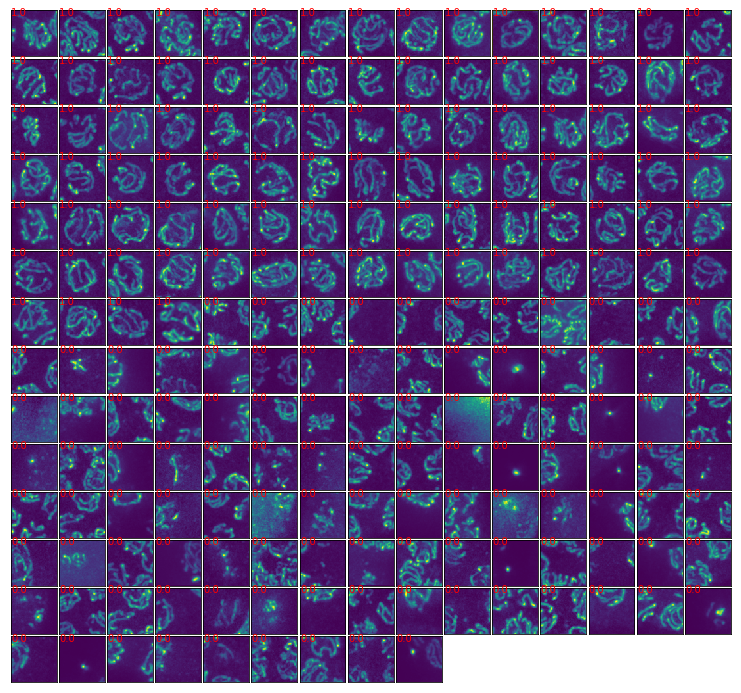

In [17]:
Nbr_row_col = int(np.ceil(np.sqrt(len(X))))
# set up the figure
fig = plt.figure(figsize=(10, 10))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the faces:
for i in range(len(X)):
    ax = fig.add_subplot(Nbr_row_col, Nbr_row_col, i + 1, xticks=[], yticks=[])
    ax.imshow(X[i, :, :], interpolation='nearest')
    ax.text(0, 7, str(Y[i]), color="red")

# Split data into training set and test set

In [18]:
from sklearn.model_selection import train_test_split

### First we convert all the images into HoG Features

In [19]:
#HoG descriptor
dat = []
for data in X:
    dat.append(hog(data, orientations=8, pixels_per_cell=(6, 6), block_norm = 'L1',
                    cells_per_block=(3, 3), visualize=False, multichannel=False))
dat = np.asarray(dat)

In [20]:
dat.shape

(204, 5832)

### Then we split the data

In [21]:
X_train, X_test, y_train, y_test = train_test_split(dat, Y)

In [22]:
X_train.shape

(153, 5832)

# The we scale the data to avoid having one feature beging disporportionaly important 

In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [25]:
X_train = scaler.transform(X_train)

In [26]:
X_test = scaler.transform(X_test)

Some help on how to chose your estimator:
https://scikit-learn.org/stable/tutorial/machine_learning_map/

In [27]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [28]:
clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [29]:
pred = clf.predict(X_test)

In [31]:
res = clf.predict_proba(X_test)

### Evaluation of the object detection  (our classifier)

In [32]:
print(confusion_matrix(y_test,pred))

[[29  0]
 [ 0 22]]


In [33]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        29
         1.0       1.00      1.00      1.00        22

   micro avg       1.00      1.00      1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51



The precision tell me that from the number of chromosome the classifier found, how many were true.
Recall tell me, out of all the chromosome I was suppose to found, how many did I found. 

# Learning curve

Will allow to find if our learning algorithm suffer from high bias (underfit) or high variance (overfitting)

In [34]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, Y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

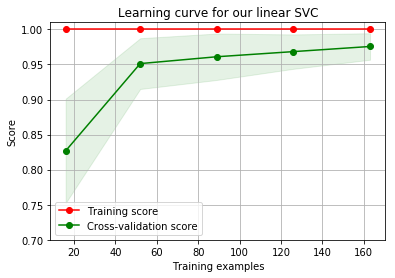

In [35]:
title = "Learning curve for our linear SVC"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = clf
plot_learning_curve(estimator, title, dat, Y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

# We can now save our classifier and scaler

In [36]:
import os

In [37]:
path = "/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/clf_scaler/"

In [38]:
def save_file(path, filename, data):
    if os.path.isfile(path+filename+".npy"):
        expand = 0
        while True:
            expand += 1
            new_filename = filename + "_" + str(expand)
            if os.path.isfile(path+new_filename):
                continue
            else:
                filename = new_filename
            break
    np.save(path+filename, data)

In [39]:
save_file(path, "clf", clf)
save_file(path, "scaler", scaler)